<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 8.4: Sentiment Analysis
INSTRUCTIONS:
- Run the cells
- Observe and understand the results
- Answer the questions

Based on the video tutorial **Text Classification with Machine Learning,SpaCy and Scikit(Sentiment Analysis)** by **Jesse E. Agbe (JCharis)**.

## Data Source: UCI
### UCI - Machine Learning Repository
- Center for Machine Learning and Intelligent Systems

The [**UCI Machine Learning Repository**](http://archive.ics.uci.edu/ml/about.html) is a collection of databases, domain theories, and data generators that are used by the machine learning community for the empirical analysis of machine learning algorithms.

### Dataset
- [Sentiment Labelled Sentences Data Set](http://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences)

### Abstract
The dataset contains sentences labelled with positive or negative sentiment.

- Data Set Characteristics: Text
- Number of Instances: 3000
- Area: N/A
- Attribute Characteristics: N/A
- Number of Attributes: N/A
- Date Donated: 2015-05-30
- Associated Tasks: Classification
- Missing Values? N/A
- Number of Web Hits: 102584

### Source
Dimitrios Kotzias dkotzias '@' ics.uci.edu

### Data Set Information
This dataset was created for the Paper 'From Group to Individual Labels using Deep Features', Kotzias et. al,. KDD 2015

Please cite the paper if you want to use it :)

It contains sentences labelled with positive or negative sentiment.

### Format
sentence &lt;tab&gt; score &lt;newline&gt;

### Details
Score is either 1 (for positive) or 0 (for negative)

The sentences come from three different websites/fields:
- imdb.com
- amazon.com
- yelp.com

For each website, there exist **500 positive** and **500 negative** sentences. Those were selected randomly for larger datasets of reviews.

We attempted to select sentences that have a clearly positive or negative connotaton, the goal was for no neutral sentences to be selected.

For the full datasets look:

- **imdb**: Maas et. al., 2011 _Learning word vectors for sentiment analysis_
- **amazon**: McAuley et. al., 2013 _Hidden factors and hidden topics: Understanding rating dimensions with review text_
- **yelp**: [Yelp dataset challenge](http://www.yelp.com/dataset_challenge)


### Attribute Information
The attributes are text sentences, extracted from reviews of products, movies, and restaurants

### Relevant Papers
**From Group to Individual Labels using Deep Features**, Kotzias et. al,. KDD 2015

### Citation Request
**From Group to Individual Labels using Deep Features**, Kotzias et. al,. KDD 2015

## Import libraries

In [35]:
## Import Libraries
import pandas as pd
import numpy as np

import regex as re
import spacy

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import warnings
warnings.filterwarnings('ignore')

## Load data

Load Yelp, Amazon and Imdb Data.

Hint: Source is separated by tabs and has no headers.

In [2]:
yelp_text = '/Users/stephanienduaguba/Documents/DATA/yelp_labelled.txt' # 'yelp_labelled.txt'
imdb_text = '/Users/stephanienduaguba/Documents/DATA/imdb_labelled_fixed.txt' # 'imdb_labelled_fixed.txt'
amazon_text = '/Users/stephanienduaguba/Documents/DATA/amazon_cells_labelled.txt' # 'amazon_cells_labelled.txt'

# ANSWER
df_yelp = pd.read_csv(yelp_text, header = None, sep = '\t')
df_imdb = pd.read_csv(imdb_text, header = None, sep = '\t')
df_amazon = pd.read_csv(amazon_text, header = None, sep = '\t')
dfs = {'yelp': df_yelp, 'imdb': df_imdb, 'amazon': df_amazon}

## Inspect the data

Check your datasets.

In [3]:
# ANSWER
# View data
dfs

{'yelp':                                                      0  1
 0                             Wow... Loved this place.  1
 1                                   Crust is not good.  0
 2            Not tasty and the texture was just nasty.  0
 3    Stopped by during the late May bank holiday of...  1
 4    The selection on the menu was great and so wer...  1
 ..                                                 ... ..
 995  I think food should have flavor and texture an...  0
 996                           Appetite instantly gone.  0
 997  Overall I was not impressed and would not go b...  0
 998  The whole experience was underwhelming, and I ...  0
 999  Then, as if I hadn't wasted enough of my life ...  0
 
 [1000 rows x 2 columns],
 'imdb':                                                      0  1
 0    A very, very, very slow-moving, aimless movie ...  0
 1    Not sure who was more lost - the flat characte...  0
 2    Attempting artiness with black & white and cle...  0
 3         V

In [4]:
# Useful code to view data
for ds in dfs.keys():
    print('Dataset: %s [%d row(s) x %d col(s)]' % (ds, dfs[ds].shape[0], dfs[ds].shape[1]))
    dfs[ds].columns = ['text', 'sentiment']
    dfs[ds]['source'] = ds
    print(dfs[ds].head())
    print('-' * 75)

Dataset: yelp [1000 row(s) x 2 col(s)]
                                                text  sentiment source
0                           Wow... Loved this place.          1   yelp
1                                 Crust is not good.          0   yelp
2          Not tasty and the texture was just nasty.          0   yelp
3  Stopped by during the late May bank holiday of...          1   yelp
4  The selection on the menu was great and so wer...          1   yelp
---------------------------------------------------------------------------
Dataset: imdb [1000 row(s) x 2 col(s)]
                                                text  sentiment source
0  A very, very, very slow-moving, aimless movie ...          0   imdb
1  Not sure who was more lost - the flat characte...          0   imdb
2  Attempting artiness with black & white and cle...          0   imdb
3       Very little music or anything to speak of.            0   imdb
4  The best scene in the movie was when Gerardo i...          1  

## Merge the data

Merge all three datasets.

In [6]:
# ANSWER
# Merging data
df = pd.concat(dfs.values(), ignore_index=True)

In [8]:
# Print merged data
print('Dataset: %s [%d row(s) x %d col(s)]\n' % ('All', df.shape[0], df.shape[1]))
print(df.info())
print(df.sample(10))

Dataset: All [3000 row(s) x 3 col(s)]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       3000 non-null   object
 1   sentiment  3000 non-null   int64 
 2   source     3000 non-null   object
dtypes: int64(1), object(2)
memory usage: 70.4+ KB
None
                                                   text  sentiment  source
2192  Lately they have been extremely nice and helpf...          1  amazon
1393  Having to humour him just to get by and get th...          1    imdb
998   The whole experience was underwhelming, and I ...          0    yelp
2527                   The noise shield is incrediable.          1  amazon
2371  Display is excellent and camera is as good as ...          1  amazon
745   There was a warm feeling with the service and ...          1    yelp
2872  I was very pleased to see that I could replace...          1  amazon
2584

## Export the data

Export merged datasets to as csv file.

In [9]:
# ANSWER
# Export merged dataset to csv file
csv_path = '/Users/stephanienduaguba/Documents/DATA/sentiments.csv'
df.to_csv(csv_path, index=None)

## Prepare the stage
- Load spaCy

In [11]:
nlp = spacy.load("en_core_web_sm")

## Prepare the text
All the text handling and preparation concerned with the changes and modifications from the raw source text to a format that will be used for the actual processing, things like:
- handle encoding
- handle extraneous and international characters
- handle symbols
- handle metadata and embedded information
- handle repetitions (such as multiple spaces or newlines)

Clean text.

In [12]:
def clean_text(text):
    # reduce multiple spaces and newlines to only one
    text = re.sub(r'(\s\s+|\n\n+)', r'\1', text)
    # remove double quotes
    text = re.sub(r'"', '', text)

    return text

In [13]:
df

,text,sentiment,source
0,Wow... Loved this place.,1,yelp
1,Crust is not good.,0,yelp
2,Not tasty and the texture was just nasty.,0,yelp
3,Stopped by during the late May bank holiday of...,1,yelp
4,The selection on the menu was great and so wer...,1,yelp
...,...,...,...
2995,The screen does get smudged easily because it ...,0,amazon
2996,What a piece of junk.. I lose more calls on th...,0,amazon
2997,Item Does Not Match Picture.,0,amazon
2998,The only thing that disappoint me is the infra...,0,amazon


In [16]:
# ANSWER
# Apply function to clean text
df['text'] = df['text'].apply(clean_text)

## Work the text
Concern with the meaning and the substance of the content to extract actual information.

Hint: Use techniques learned in previous labs. Remove StopWords, Punctuation, Lemmatize etc.

In [17]:
# Define a function to convert text
def convert_text(text):
    # Process the input text using spaCy
    sent = nlp(text)

    # Create a dictionary of named entities in the sentence
    ents = {x.text: x for x in sent.ents}

    # Initialize an empty list to store processed tokens
    tokens = []

    # Iterate through each word in the sentence
    for w in sent:
        # Skip stopwords, punctuation, and digits
        if w.is_stop or w.is_punct or w.is_digit:
            continue
        
        # If the word is a named entity, use its original text
        if w.text in ents:
            tokens.append(w.text)
        # If the word is not a named entity, use its lemmatized and lowercase form
        else:
            tokens.append(w.lemma_.lower())

    # Join the processed tokens into a single string
    text = ' '.join(tokens)

    # Return the processed text
    return text

In [18]:
%%time
df['short'] = df['text'].apply(convert_text)

CPU times: user 9.8 s, sys: 52.3 ms, total: 9.85 s
Wall time: 9.89 s


In [19]:
df.sample(10)

,text,sentiment,source,short
2482,"After charging overnight, these batteries work...",1,amazon,charge overnight battery work great
1222,Mishima is extremely uninteresting.,0,imdb,Mishima extremely uninteresting
1488,I particularly remember my senses being assaul...,0,imdb,particularly remember sense assault strident c...
1241,This would not even be good as a made for TV f...,0,imdb,good tv flick
151,This is a great restaurant at the Mandalay Bay.,1,yelp,great restaurant mandalay bay
1803,The acting from all involved and that includes...,0,imdb,acting involve include like Shatner Nimoy bad ...
1292,An AMAZING finale to possibly the BEST trilogy...,1,imdb,amazing finale possibly best trilogy time
892,Pricing is a bit of a concern at Mellow Mushroom.,0,yelp,pricing bit concern mellow mushroom
996,Appetite instantly gone.,0,yelp,Appetite instantly go
1266,Thanks good a movie like this was done and rel...,1,imdb,thank good movie like release


## Modelling

In [20]:
# helper function to show results and charts
def show_summary_report(actual, prediction, probabilities):

    # Convert labels to integer
    if isinstance(actual, pd.Series):
        actual = actual.values.astype(int)
    prediction = prediction.astype(int)

    # Calculate metrics
    accuracy_ = accuracy_score(actual, prediction)
    precision_ = precision_score(actual, prediction)
    recall_ = recall_score(actual, prediction)
    roc_auc_ = roc_auc_score(actual, probabilities)

    print('Accuracy : %.4f [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0' % accuracy_)
    print('Precision: %.4f [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0' % precision_)
    print('Recall   : %.4f [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0' % recall_)
    print('ROC AUC  : %.4f                                                                     Best: 1, Worst: < 0.5' % roc_auc_)
    print('-' * 107)
    print('TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples')

    # Confusion Matrix
    mat = confusion_matrix(actual, prediction)

    # Precision/Recall
    precision, recall, _ = precision_recall_curve(actual, probabilities)
    average_precision = average_precision_score(actual, probabilities)
    
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(actual, probabilities)
    roc_auc = auc(fpr, tpr)


    # plot
    fig, ax = plt.subplots(1, 3, figsize = (18, 6))
    fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.2)

    # Confusion Matrix
    sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Blues', ax = ax[0])

    ax[0].set_title('Confusion Matrix')
    ax[0].set_xlabel('True label')
    ax[0].set_ylabel('Predicted label')
    
    # Precision/Recall
    step_kwargs = {'step': 'post'}
    ax[1].step(recall, precision, color = 'b', alpha = 0.2, where = 'post')
    ax[1].fill_between(recall, precision, alpha = 0.2, color = 'b', **step_kwargs)
    ax[1].set_ylim([0.0, 1.0])
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('2-class Precision-Recall curve')

    # ROC
    ax[2].plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC curve (AUC = %0.2f)' % roc_auc)
    ax[2].plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
    ax[2].set_xlim([0.0, 1.0])
    ax[2].set_ylim([0.0, 1.0])
    ax[2].set_xlabel('False Positive Rate')
    ax[2].set_ylabel('True Positive Rate')
    ax[2].set_title('Receiver Operating Characteristic')
    ax[2].legend(loc = 'lower right')

    plt.show()
    
    return (accuracy_, precision_, recall_, roc_auc_)

In [21]:
# Features and Labels
X = df['short']
y = df['sentiment']

# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## Use Bag-of-Words

In [22]:
# create a matrix of word counts from the text
counts = CountVectorizer()

In [23]:
# do the actual counting
A = counts.fit_transform(X_train, y_train)

In [28]:
# What A looks like after BOW
pd.DataFrame(A.todense(), columns=counts.get_feature_names_out()).head()

,00,10,11,13,15,15pm,17,20th,2mp,30,...,yucky,yukon,yum,yummy,yun,z500a,zero,zillion,zombie,zombiez
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
# create a classifier using SVC
classifier = SVC(kernel='linear', probability=True)

In [30]:
# train the classifier with the training data
classifier.fit(A.toarray(), y_train)

SVC(kernel='linear', probability=True)

In [31]:
# do the transformation for the test data
# NOTE: use `transform()` instead of `fit_transform()`
B = counts.transform(X_test)

In [36]:
# make predictions based on the test data
predictions = classifier.predict(np.asarray(B.todense()))

# store probabilities of predictions being 1
probabilities = classifier.predict_proba(np.asarray(B.todense()))[:, 1]

In [37]:
# check the accuracy
print('Accuracy: %.4f' % accuracy_score(y_test, predictions))

Accuracy: 0.7833


## Repeat using TF-IDF
TF-IDF = Term Frequency - Inverse Document Frequency

In [41]:
# create a matrix of word counts from the text
# use TF-IDF
tfidf = TfidfVectorizer()
# do the actual counting
A = tfidf.fit_transform(X_train, y_train)

# train the classifier with the training data
classifier.fit(A.toarray(), y_train)

# do the transformation for the test data
# NOTE: use `transform()` instead of `fit_transform()`
B = tfidf.transform(X_test)

# make predictions based on the test data
predictions = classifier.predict(np.asarray(B.todense()))

# store probabilities of predictions being 1
probabilities = classifier.predict_proba(np.asarray(B.todense()))[:, 1]

# check the accuracy
print('Accuracy: %.4f' % accuracy_score(y_test, predictions))

Accuracy: 0.7833


In [43]:
# What does A look like after TF-IDF?

pd.DataFrame(A.todense(), columns=counts.get_feature_names_out()).head()

,00,10,11,13,15,15pm,17,20th,2mp,30,...,yucky,yukon,yum,yummy,yun,z500a,zero,zillion,zombie,zombiez
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Repeating it all for comparision
Repeating the whole lot in one big block

Find 'Accuracy', 'Precision', 'Recall', 'ROC_AUC' using CountVectorizer and TfidfVectorizer and keep the result in a dataframe.

*********
* Count *
*********
Accuracy : 0.7833 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7959 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7697 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8780                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


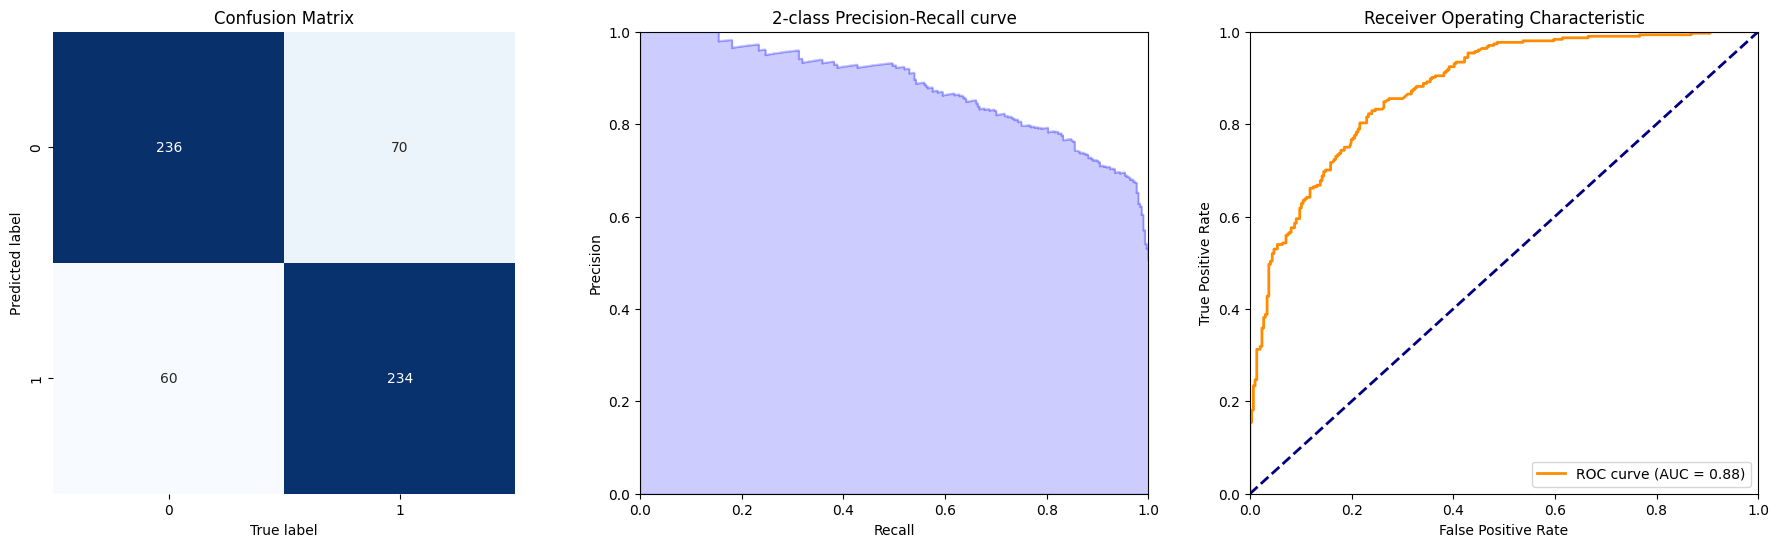

**********
* TF-IDX *
**********
Accuracy : 0.7833 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7939 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7730 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8833                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


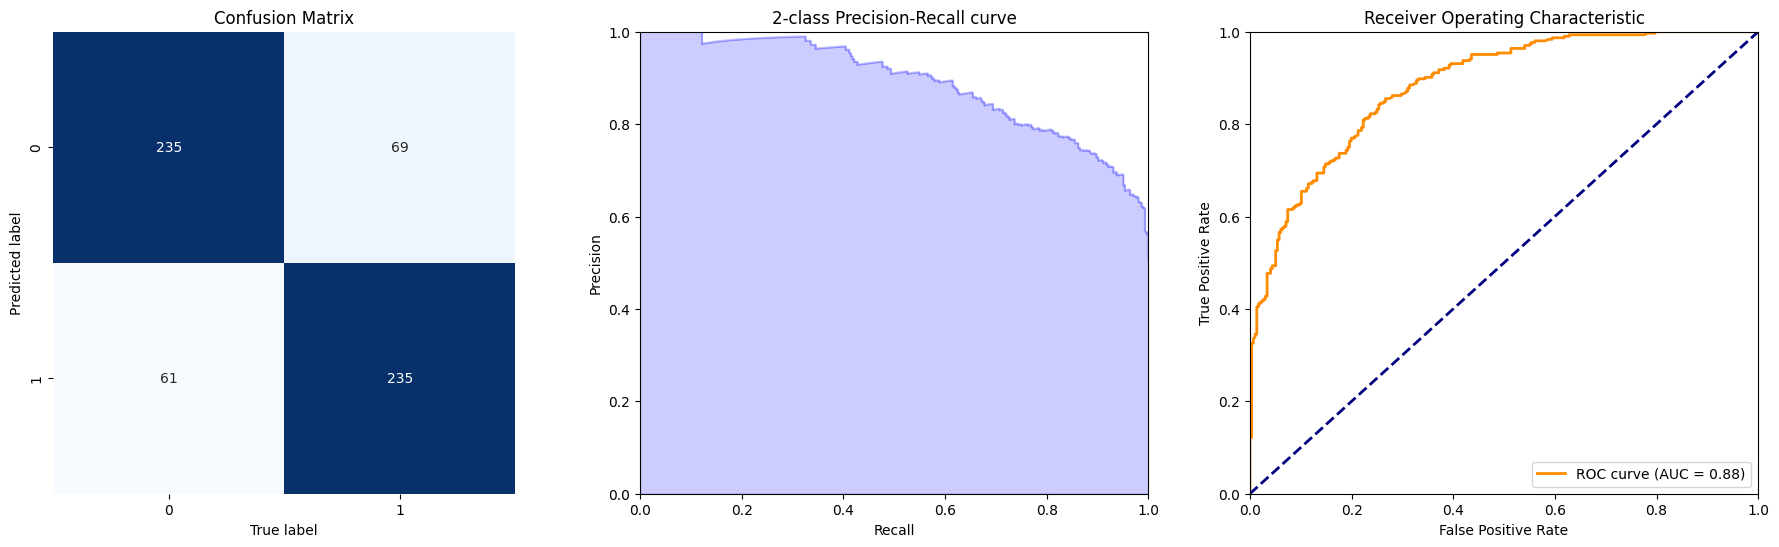

In [45]:
# ANSWER

# Keep the results in a dataframe
results = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'ROC_AUC'])

models = ['Count', 'TF-IDX']
for i, m in enumerate([CountVectorizer(), TfidfVectorizer()]):
    print('*' * (len(models[i]) + 4))
    print('* %s *' % models[i])
    print('*' * (len(models[i]) + 4))

    # create a matrix of word counts from the text
    # use TF-IDF
    counts = m
    # do the actual counting
    A = counts.fit_transform(X_train, y_train)

    # create a classifier using SVC
    classifier = SVC(kernel='linear', probability=True)

    # train the classifier with the training data
    classifier.fit(A.toarray(), y_train)

    # do the transformation for the test data
    # NOTE: use `transform()` instead of `fit_transform()`
    B = counts.transform(X_test)

    # make predictions based on the test data
    predictions = classifier.predict(np.asarray(B.todense()))

    # store probabilities of predictions being 1
    probabilities = classifier.predict_proba(np.asarray(B.todense()))[:, 1]

    # show the report
    accuracy_, precision_, recall_, roc_auc_ = show_summary_report(y_test, predictions, probabilities)
    # keep the results
    results.loc[i] = {'Model': models[i],
                      'Accuracy': accuracy_,
                      'Precision': precision_,
                      'Recall': recall_,
                      'ROC_AUC': roc_auc_}

In [46]:
# print results dataframe

results

,Model,Accuracy,Precision,Recall,ROC_AUC
0,Count,0.783333,0.795918,0.769737,0.878045
1,TF-IDX,0.783333,0.793919,0.773026,0.883329




---



---



> > > > > > > > > © 2023 Institute of Data


---



---



